In [1]:
import numpy as np
import random
import os
import shutil

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

map_dir = 'map 3'

remove prev saved database:

In [2]:
dir_path = './data/humanModel_dataset_split'
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
else:
    print("File not found in the directory")

# Part 1 - Data Preprocessing

## Split into train , test data

In [3]:
# train, test split
splitfolders.ratio('./data/humanModel_dataset/', output="./data/humanModel_dataset_split", ratio=(0.7, 0.3))

Copying files: 5834 files [00:00, 15985.13 files/s]


### Preprocessing the Training set

In [4]:
batch_size = 64
IMG_SIZE = 10

datagen = ImageDataGenerator(rescale = 1./255)
train = datagen.flow_from_directory('./data/humanModel_dataset_split/train',
                                          target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

test = datagen.flow_from_directory('./data/humanModel_dataset_split/val',
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

Found 4081 images belonging to 5 classes.
Found 1753 images belonging to 5 classes.


## View some data

In [5]:
num_classes = 5

model = Sequential([
  layers.Conv2D(8, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[IMG_SIZE,IMG_SIZE,3]),
  layers.Conv2D(16, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(num_classes, activation='softmax')
])

2021-12-20 16:14:46.133632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 16:14:46.137806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 16:14:46.138094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 16:14:46.138853: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 8)         392       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2064      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 8)           1160      
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0

In [8]:
epochs=150
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs
)

2021-12-20 16:14:46.783549: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/home/ido/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


Epoch 1/150


2021-12-20 16:14:47.435040: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8300


64/64 [==============================] - 2s 15ms/step - loss: 1.6218 - accuracy: 0.3252 - val_loss: 1.4035 - val_accuracy: 0.5533
Epoch 2/150
64/64 [==============================] - 1s 12ms/step - loss: 1.3068 - accuracy: 0.5244 - val_loss: 1.1226 - val_accuracy: 0.5750
Epoch 3/150
64/64 [==============================] - 1s 12ms/step - loss: 1.1643 - accuracy: 0.5719 - val_loss: 1.0318 - val_accuracy: 0.6395
Epoch 4/150
64/64 [==============================] - 1s 11ms/step - loss: 1.0807 - accuracy: 0.6217 - val_loss: 0.9800 - val_accuracy: 0.6520
Epoch 5/150
64/64 [==============================] - 1s 12ms/step - loss: 1.0167 - accuracy: 0.6604 - val_loss: 0.9265 - val_accuracy: 0.6629
Epoch 6/150
64/64 [==============================] - 1s 11ms/step - loss: 0.9803 - accuracy: 0.6682 - val_loss: 0.9150 - val_accuracy: 0.6828
Epoch 7/150
64/64 [==============================] - 1s 11ms/step - loss: 0.9483 - accuracy: 0.6812 - val_loss: 0.8905 - val_accuracy: 0.7068
Epoch 8/150
64/64 

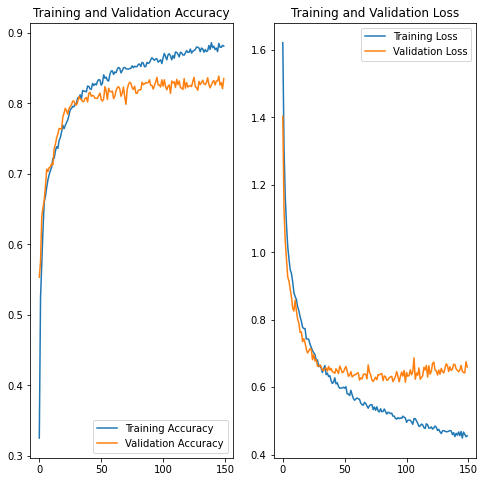

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

28/28 [==============================] - 0s 9ms/step - loss: 0.6599 - accuracy: 0.8351
Test accuracy : 0.8351397514343262


In [11]:
# Save the entire model as a SavedModel.
# model.save('./data/humanModel/mode_v0')
model.save('./data/'+map_dir+'/humanModel_v0.h5')

In [12]:
# save model in js format
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'data/humanModel/js_model_v0')

In [13]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [14]:
sunflower_path = "./data/humanModel_dataset_split/val/39/-Mr4bNQJo1l3U7zrP2PJ_62.png"

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(score), 100 * np.max(score))
)

This image most likely belongs to 1 with a 40.35 percent confidence.
